<font size="1">
Supplementary code for "Build a Large Language Model From Scratch": <a href="https://www.manning.com/books/build-a-large-language-model-from-scratch">https://www.manning.com/books/build-a-large-language-model-from-scratch</a> by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>

# Chapter 5: 在未标记数据上进行预训练

In [41]:
from importlib.metadata import version

pkgs = ["matplotlib", "numpy", "tiktoken", "torch"]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.2.4
tiktoken version: 0.9.0
torch version: 2.6.0


- 在本章中，我们将实现训练循环及基本模型评估代码，以预训练一个LLM
- 本章结尾处，我们还将加载OpenAI提供的公开可用的预训练权重并将其导入到我们的模型中

<img src="images/img-1.webp" width=500px>

- 本章所涵盖的主题如下图所示

<img src="images/img-2.webp" width=400px>

## 5.1 评估文本生成模型

- 我们首先简要回顾一下使用上一章中的代码初始化 GPT 模型
- 然后，我们讨论 LLM 的基本评估指标
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集

### 5.1.1 使用 GPT 生成文本

- 我们使用上一章中的代码初始化 GPT 模型

In [9]:
import torch
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "ctx_len": 256,       # Shortened context length (orig: 1024)
    "emb_dim": 768,       # Embedding dimension
    "n_heads": 12,        # Number of attention heads
    "n_layers": 12,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- 我们在上面使用0.1的dropout，但现在的llm训练中通常没有dropout
- 现在的llm也不会在查询，键和值矩阵的`nn.Linear`层中使用偏差向量 (与早期的GPT模型不同)，这是通过设置`“qkv_bias”: False`来实现的
- 我们只用256个token的上下文长度 (`ctx_len`)，以减少训练模型的计算资源需求，而原始的1.24亿参数GPT-2模型使用1024个token
  - 这是为了让更多的读者能够在他们的笔记本电脑上执行代码示例
  - 但是，请随意增加`ctx_len`到1024token (这不需要任何代码更改)
  - 之后我们还将从预训练的权重加载具有`ctx_len = 1024`的模型

- 接下来，我们使用上一章中的`generate_text_simple`函数来生成文本。
- 此外，我们定义了两个函数`text_to_token_ids`和`token_ids_to_text`，用于在本章中进行标记和文本表示之间的转换。

<img src="images/img-3.webp" width=500px>

In [25]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 增加batch维度
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 去掉batch维度
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids(start_context, tokenizer),
#     max_new_tokens=10,
#     context_size=GPT_CONFIG_124M["ctx_len"]
# )
start_ids = text_to_token_ids(text=start_context, tokenizer=tokenizer)
print(f"Input token ids are: \n{start_ids}\n")

# 回顾一下嵌入层的输出：
input_embbed = model.tok_emb(start_ids)
print(f"input embbeding's shape is: {input_embbed.shape}\n")
print(f"input embbeding are: \n{input_embbed}\n")

token_ids = generate_text_simple(
    model=model,
    idx=start_ids,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["ctx_len"]
)
print(f"Output token ids' shape: {token_ids.shape}")
print(f"Output token ids are: \n{token_ids}\n")
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Input token ids are: 
tensor([[6109, 3626, 6100,  345]])

input embbeding's shape is: torch.Size([1, 4, 768])

input embbeding are: 
tensor([[[ 1.6146,  2.1622,  1.2770,  ...,  0.0111, -1.1353, -0.2450],
         [-1.6020, -1.3996,  0.4308,  ...,  0.0913, -0.0614, -0.0538],
         [ 0.7265,  1.0869, -0.2251,  ..., -0.0742,  0.1081,  0.9774],
         [-0.4047, -0.0914, -1.5747,  ..., -1.5130,  0.4232,  0.5841]]],
       grad_fn=<EmbeddingBackward0>)

Output token ids' shape: torch.Size([1, 14])
Output token ids are: 
tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 如上所述，模型未能生成好的文本，因为它尚未经过训练。
- 我们如何以数值形式衡量或捕捉“好的文本”，以便在训练过程中进行跟踪？
- 下一小节将介绍用于计算生成输出的损失指标的度量标准，我们可以使用这些度量标准来衡量训练进度。
- 在后续关于微调大型语言模型（LLMs）的章节中，也将介绍其他衡量模型质量的方法。

### 5.1.2 计算文本生成损失：交叉熵和困惑度

- 假设我们有一个`inputs`张量，包含了2个训练样本（行）的标记ID。
- 对应于`inputs`，`targets`包含了我们希望模型生成的期望标记ID。
- 请注意，`targets`是`inputs`向右移动了一个位置，正如第2章中实现数据加载器时所解释的那样。

In [44]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [588,  428,  11311]]) #  " really like chocolate"]

- 将`inputs`输入模型后，我们获得了包含3个标记的2个输入样本的logits向量。
- 每个标记都是一个50,257维的向量，对应于词汇表的大小。
- 应用softmax函数，我们可以将logits张量转换为一个相同维度的张量，其中包含概率分数。

In [45]:
with torch.no_grad():
    logits = model(inputs)

print(f"logits's shape: {logits.shape}")
print(f"logits: \n{logits}\n")
probas = torch.softmax(logits, dim=-1) # 词表中每个标记的预测概率
print(f"probas's shape: {probas.shape}") # Shape: (batch_size, num_tokens, vocab_size)
print(f"probas: \n{probas}\n")

logits's shape: torch.Size([2, 3, 50257])
logits: 
tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

        [[-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
         [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
         [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]]])

probas's shape: torch.Size([2, 3, 50257])
probas: 
tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0537e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1207e-05,
     

- 下图为了说明目的使用了一个非常小的词汇表，概述了我们如何将概率分数转换回文本，这一点我们在上一章的末尾进行了讨论。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-to-text.webp" width=500px>

- 正如在前一章中讨论的，我们可以应用`argmax`函数将概率分数转换为预测的标记ID。
- 上文提到的softmax函数为每个标记生成了一个50,257维的向量；`argmax`函数返回这个向量中最高概率分数的位置，即给定标记的下一个预测标记ID。

- 由于我们有2个输入批次，每个批次包含3个标记，因此我们获得了2个3维的预测标记ID：

In [46]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
# 执行了argmax之后，shape由 (2, 3, 50257) 变成 (2, 3, 1)
print(f"token_ids' shape: {token_ids.shape}\n")
print("Token IDs:\n", token_ids)

token_ids' shape: torch.Size([2, 3, 1])

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们解码这些标记，我们会发现它们与我们希望模型预测的标记，即目标标记，相当不同：

In [47]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 那是因为模型还没有被训练。
- 为了训练模型，我们需要知道它离正确预测（目标）有多远。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/proba-index.webp" width=500px>

- 对应于目标索引的标记概率如下：

In [48]:
batch_idx = 0
print(f"targets[{batch_idx}]: {targets[batch_idx]}")
target_probas_1 = probas[batch_idx, [0, 1, 2], targets[batch_idx]]
print("Batch 1:", target_probas_1) # 等价于：print(probas[batch_idx][0][3626], probas[batch_idx][1][6100], probas[batch_idx][2][345])

batch_idx = 1
target_probas_2 = probas[1, [0, 1, 2], targets[1]]
print("Batch 2:", target_probas_2)

targets[0]: tensor([3626, 6100,  345])
Batch 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Batch 2: tensor([3.9835e-05, 1.6783e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使它们接近1的概率。
- 在数学优化中，最大化概率分数的对数比分数值本身更容易；这超出了本书的范围，但我在这里录制了一个更详细的讲座：[L8.2 逻辑回归损失函数](https://www.youtube.com/watch?v=GxJe0DZvydM)。

In [49]:
# 计算所有标记的预测概率的对数值
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -10.1308, -10.9951, -12.2561])


- 接下来，我们计算平均对数概率：

In [50]:
# 对所有标记的概率对数值求均值
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7722)


- 目标是通过优化模型权重，使得这个平均对数概率尽可能大。
- 由于对数函数的特性，最大可能的值是0，而我们目前远离0。

- 在深度学习中，我们通常不是最大化平均对数概率，而是遵循标准惯例来最小化平均对数概率的*负值*；在我们的例子中，不是最大化-10.7722使其接近0，在深度学习中，我们会最小化10.7722使其接近0。
- 负-10.7722的值，即10.7722，在深度学习中也被称为交叉熵损失。

In [51]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7722)


- PyTorch 已经实现了一个 `cross_entropy` 函数，该函数执行了前面的步骤。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/cross-entropy.webp" width=400px>

- 在我们应用交叉熵函数之前，让我们先检查一下logits和targets的形状。

In [52]:
# Logits向量的形状 (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# 目标向量的形状 (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于PyTorch中的`entropy_loss`函数，我们希望通过在批次(batch)维度上合并它们来展平(flatten)这些张量：

In [53]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 请注意，目标（targets）是标记ID，它们也代表了我们希望在logits张量中最大化的索引位置。
- PyTorch中的`cross_entropy`函数会自动地将softmax和对数概率计算应用到这些要最大化标记索引的logits上

In [54]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7722)


- 一个 与交叉熵损失相关的概念是大型语言模型（LLM）的困惑度。
- 困惑度简单地说就是交叉熵损失的指数函数计算结果

In [55]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(47678.8672)


- 困惑度通常被认为更具可解释性，因为它可以被理解为模型在每一步中对下一标记所不确定的词表大小（在上面的例子中，这将是47,678个单词或标记）。
- 换句话说，困惑度提供了一种衡量模型预测的概率分布与数据集中单词实际分布匹配程度的方法。
- 与损失类似，较低的困惑度表明模型预测更接近实际分布。

### 5.1.3 计算训练集和验证集损失

- 我们使用一个相对较小的数据集来训练大型语言模型（LLM）（实际上，只有一个短篇故事）。
  - 原因包括：
    - 你可以在没有合适GPU的笔记本电脑上在几分钟内运行代码示例。
    - 训练完成得相对较快（几分钟而不是几周），这对我们的教育目的来说很好。
    - 我们使用的是公有领域的文本，可以包含在这个GitHub仓库中而不会违反任何使用权或增加仓库大小。

- 例如，Llama 2 7B在A100 GPU上需要184,320小时的训练时间才能在2万亿个标记上完成训练。
  - 在撰写本文时，AWS上8xA100云服务器的每小时成本大约为30美元。
  - 因此，通过一个粗略的计算，训练这个LLM的成本将是 184,320 / 8 * 30美元 = 69万美元。

- 下面，我们将使用第2章中使用过的相同数据集。

In [19]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://github.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 通过打印前100个和后100个单词来快速检查文本是否正确加载。

In [57]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [58]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [59]:
total_char = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_char)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- 虽然只有5,145个标记，对于训练一个大型语言模型（LLM）来说，这段文本非常短，但再次强调，这是出于教育目的（我们稍后还会加载预训练的权重）。

- 接下来，我们将数据集划分为训练集和验证集，并使用第2章中的数据加载器为大型语言模型（LLM）训练准备批次数据。
- 为了可视化目的，下面的图表假设`max_length=6`，但对于训练加载器，我们将`max_length`设置为LLM支持的上下文长度。
- 下面的图表仅显示输入标记以简化表示。
  - 由于我们训练LLM来预测文本中的下一个单词，目标标记看起来与这些输入标记相同，只是目标标记向右移动了一个位置。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/batching.webp" width=500px>

In [20]:
from previous_chapters import create_dataloader_v1

# 训练集/验证集数据比
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["ctx_len"],
    stride=GPT_CONFIG_124M["ctx_len"],
    drop_last=True,
    shuffle=True
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["ctx_len"],
    stride=GPT_CONFIG_124M["ctx_len"],
    drop_last=False,
    shuffle=False
)

In [61]:
# 合理性检查：为了确保训练集和验证集中数据量大于模型的上下文窗口，避免出现训练/验证错误

if total_tokens * (train_ratio) < GPT_CONFIG_124M["ctx_len"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['ctx_len']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["ctx_len"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['ctx_len']` or "
          "decrease the `training_ratio`")

- 我们使用相对较小的批次大小来减少计算资源的需求，并且因为数据集本身起初就非常小。
- 例如，Llama 2 7B就是使用1024的批次大小进行训练的。

- 一个可选的检查，以确认数据是否已正确加载：

In [62]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选的检查，以确认标记大小是否在预期的范围内：

In [63]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() # 使用numel()函数统计一个batch中的token数量

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们实现一个实用工具函数来计算给定批次的交叉熵损失。
- 此外，我们实现了第二个实用工具函数，用于计算数据加载器中用户指定数量批次的总损失。

In [15]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    logits = model(input_batch)
    logits = logits.flatten(0, 1)
    loss = torch.nn.functional.cross_entropy(logits, target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None): # num_batches为计算损失的批次范围
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        # 取num_batches和len(data_loader)两者较小值以匹配data_loader中的总批次数量
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果你拥有一台装有支持CUDA的GPU的计算机，大型语言模型（LLM）将在GPU上进行训练，无需对代码做任何更改。
- 通过`device`设置，我们确保数据被加载到与LLM模型相同的设备上。

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # 对于nn.Module类的模型，不需要执行model = model.to(device)这样的赋值操作。


torch.manual_seed(123) # 出于代码结果的可复现性的考虑，显式地设定manual_seed
train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

NameError: name 'train_loader' is not defined

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-1.webp" width=400px>

## 5.2 训练一个大型语言模型（LLM）

- 在本节中，我们最终实现了训练大型语言模型（LLM）的代码。
- 我们专注于一个简单的训练函数（如果你对使用更先进的技术增强这个训练函数感兴趣，例如学习率预热、余弦退火和梯度裁剪，请参考[Appendix D](../../appendix-D/03_main-chapter-code))

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/train-steps.webp" width=300px>

In [66]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context):
    # 初始化列表以跟踪损失和已观察到的token
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 主要的训练步骤
    for epoch in range(num_epochs):
        model.train()  # 将模型设置为训练模式
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 每个epoch开始之前重新设置梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 计算损失梯度
            optimizer.step() # 利用损失梯度更新模型参数
            tokens_seen += input_batch.numel()
            global_step += 1

            # 可选的验证评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 在每个epoch完成后打印一个生成的文本示例
        generate_and_print_sample(
            model, train_loader.dataset.tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # 简洁的打印格式
    model.train()

- 现在，让我们使用上面定义的训练函数来训练大型语言模型（LLM）：

In [67]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you",
)

Ep 1 (Step 000000): Train loss 9.558, Val loss 9.856
Ep 1 (Step 000005): Train loss 7.651, Val loss 8.051
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.421, Val loss 6.812
Ep 2 (Step 000015): Train loss 5.913, Val loss 6.559
Every effort moves you, and, and,, and,,,,, and, and,,,, and,,,, and, and,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.680, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.557, Val loss 6.602
Every effort moves you, and, and the picture.                             ", and, and the, and the, and, and,
Ep 4 (Step 000030): Train loss 5.204, Val loss 6.508
Ep 4 (Step 000035): Train loss 4.865, Val loss 6.420
Every effort moves you, and I had a a a--I to the picture. "I. I had the picture. "I had the picture. I had the the picture. I had the the picture. "I had the picture. "
Ep 5 (Step 000040): Train loss 4.332, Val loss 6.328
Every effort moves you, I was a and I was a little to the pic

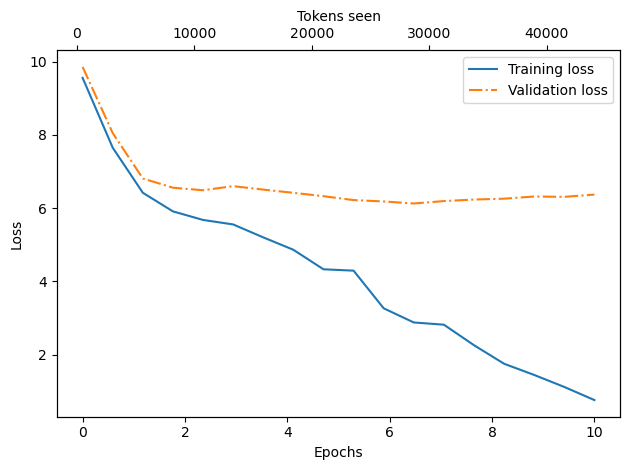

In [68]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # 绘制随着训练进行（epoch值增大）训练集损失和验证集损失的变化情况
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # 创建第二个x轴用于显示可观察的tokens
    ax2 = ax1.twiny()  # 创建一个共享相同y轴的第二个x轴
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 用于对齐刻度的不可见图表
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # 调整布局以节省空间
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 从上面的结果来看，我们可以看到模型开始生成无法理解的单词串，而到了后期，它能够产生语法上或多或少正确的句子。
- 然而，根据训练集和验证集的损失情况，我们可以看到模型开始过拟合。
- 如果我们检查它在训练结束时写的几段文本，我们会发现自己它们与训练集中的内容几乎一字不差——它只是简单地记住了训练数据。
- 稍后，我们将讨论一些解码策略，可以在一定程度上减轻这种记忆现象。
- 请注意，这里的过拟合是因为我们有一个非常非常小的训练集，而且我们多次迭代它。
  - 这里的大型语言模型训练主要是出于教育目的；我们主要想看到模型能够学习产生连贯的文本。
  - 我们不会花费数周或数月的时间在昂贵的硬件上训练这个模型，我们将在后续加载预训练的权重。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-2.webp" width=350px>

**如果您对使用更先进的技术来增强这个训练函数感兴趣，例如学习率预热、余弦退火和梯度裁剪，请参考[附录D](../../appendix-D/03_main-chapter-code)。**

**如果您对更大的训练数据集和更长时间的训练感兴趣，请查看 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)**

## 5.3 解码策略以控制随机性

- 使用相对较小的大型语言模型（如我们上面训练的GPT模型），推理过程相对廉价，因此如果您在上面使用GPU进行了训练，那么在推理时就不需要使用GPU。
- 使用我们之前在简单训练函数中使用的`generate_text_simple`函数（来自上一章），我们可以一次生成一个单词（或标记）的新文本。
- 如5.1.2节所解释的，下一个生成的标记是词汇表中所有标记中对应最大概率分数的标记。

In [69]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["ctx_len"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- 即使我们多次执行上面的`generate_text_simple`函数，大型语言模型（LLM）始终会生成相同的输出。
- 现在我们引入两个概念，所谓的解码策略，来修改`generate_text_simple`：*温度缩放*和*top-k*采样。
- 这将允许模型控制生成文本的随机性和多样性。

### 5.3.1 温度缩放

- 之前，我们总是使用`torch.argmax`采样最大概率的标记作为下一个标记。
- 为了增加多样性，我们可以使用`torch.multinomial(probs, num_samples=1)`从概率分布中采样下一个标记。
- 在这里，每个索引被选中的机会与其在输入张量中的概率相对应。

- 这里是一个关于生成下一个标记的小回顾，假设一个非常小的词汇表，仅用于说明目的：

In [70]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# 假设input是 "every effort moves you", 模型返回的logits值为下面tensor中的数值:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 下一个标记:
print(inverse_vocab[next_token_id])

forward


In [71]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [72]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)] # 使用torch.multinomial函数从probas中进行了1000次采样
    sampled_ids = torch.bincount(torch.tensor(sample)) # 使用torch.bitcount函数统计每个token的采样数量
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


- 我们不是通过`torch.argmax`来确定最可能的标记，而是使用`torch.multinomial(probas, num_samples=1)`从softmax分布中采样来确定最可能的标记。
- 为了说明，让我们看看当我们使用原始的softmax概率采样1000次下一个标记时会发生什么：

- 我们可以通过一个称为温度缩放的概念来控制分布和选择过程。
- “温度缩放”只是将logits除以一个大于0的数字的高级说法。
- 大于1的温度值将在应用softmax后导致更均匀分布的标记概率。
- 小于1的温度值将在应用softmax后导致更自信（更尖锐或更高峰）的分布。

In [73]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

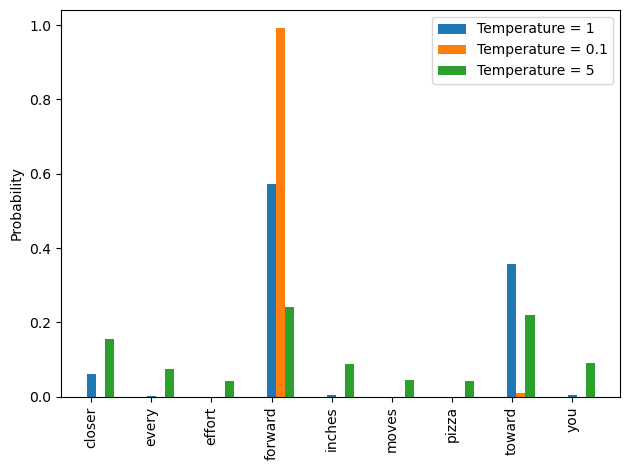

In [74]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    # 条形图的绘制，ax.bar()函数里面的参数分别为条形的x轴位置、高度、宽度、图例标签
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
# plt.savefig("temperature-plot.pdf")
plt.show()

- 我们可以看到，通过温度0.1进行重新缩放会得到一个更尖锐的分布，接近于`torch.argmax`，以至于最可能的单词几乎总是被选中：

In [75]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward


- 通过`temperature=5`重新缩放的概更加均匀：

In [76]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设大型语言模型（LLM）的输入是“every effort moves you”，使用上述方法有时会产生无意义的文本，例如“every effort moves you pizza”，这种情况发生的频率是3.2%（在1000次中有32次）。

### 5.3.2 Top-k采样

- 为了能够使用更高的温度来增加输出的多样性，并降低无意义句子出现的概率，我们可以将采样的标记限制在最可能的前k个标记中：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/topk.webp" width=500px>

- 在代码中，我们可以如下实现这一点：

In [77]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [78]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [79]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 修改文本生成函数

- 前两个小节介绍了温度采样和top-k采样。
- 让我们使用这两个概念来修改我们之前用于通过大型语言模型（LLM）生成文本的`generate_simple`函数，创建一个新的`generate`函数：

In [23]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):

    # 循环与之前相同：获取logits，并仅关注最后一步。
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 使用top_k采样对logits值进行过滤
        if top_k is not None:
            # 仅保留top_k的值
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # 使用温度缩放
        if temperature > 0.0:
            logits = logits / temperature

            # 使用softmax函数得到概率
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从概率分布中采样
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 否则和之前的generate_simple函数中的处理相同，使用argmax函数取得概率最大的token
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        # 和之前相同的序列拼接处理
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [81]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=20,
    context_size=GPT_CONFIG_124M["ctx_len"],
    top_k=10,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"," was down surprise. It is to face watching me by his painting him back to my work


## 5.4 在PyTorch中加载和保存模型权重

- 训练大型语言模型（LLM）需要昂贵的计算资源，因此能够保存和加载LLM权重至关重要。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model-3.webp" width=400px>

- PyTorch推荐的方式是保存模型权重，即所谓的`state_dict`，通过应用`torch.save`函数到`.state_dict()`方法来实现：

In [82]:
torch.save(model.state_dict(), "model.pth")

- 然后我们可以按照以下方式将模型权重加载到一个新的`GPTModel`模型实例中：

In [83]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval();

- 通常的做法是使用自适应优化器（如Adam或AdamW）而不是常规的SGD来训练大型语言模型（LLM）
- 这些自适应优化器会为每个模型权重存储额外的参数，因此如果我们计划稍后继续预训练，保存它们也是有意义的。

In [84]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [85]:
checkpoint = torch.load("model_and_optimizer.pth")

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 从Open AI加载预训练权重

- 之前，我们仅出于教育目的使用一本非常小的短篇小说书训练了一个小型的GPT-2模型。
- 感兴趣的读者还可以在[../03_bonus_pretraining_on_gutenberg](03_bonus_pretraining_on_gutenberg)中找到在完整的古登堡计划书库上进行更长时间预训练的信息。
- 幸运的是，我们不需要花费数万到数十万美元在大型预训练语料库上预训练模型，而是可以直接加载由OpenAI提供的预训练权重。

- 从Hugging Face Hub加载权重的方法，请参见[../02_alternative_weight_loading](../02_alternative_weight_loading)。

- 首先，一些模板代码用于从OpenAI下载文件并将权重加载到Python中。
- 由于OpenAI使用了[TensorFlow](https://www.tensorflow.org/)，我们将不得不安装并使用TensorFlow来加载权重；[tqdm](https://github.com/tqdm/tqdm) 是一个进度条库。
- 取消注释并运行下一个单元格以安装所需的库。

In [ ]:
# pip install tensorflow tqdm

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.


In [10]:
from importlib.metadata import version

print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [3]:
# 有关的函数导入
from gpt_download import download_and_load_gpt2

- 然后我们可以按照以下方式下载具有1.24亿参数的模型权重：

In [5]:
hparams, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json


model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [23:56<00:00, 347kiB/s]     
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 4.67MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 304kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 235kiB/s]  


note: 如果出现报错：requests.exceptions.SSLError: Max retries exceeded weith url 
更改urllib3的版本
`pip install urllib3==1.25.11`

In [6]:
print("Settings:", hparams)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [7]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


- 另外，"355M"、"774M" 和 "1558M" 也是支持的 `model_size` 参数。
- 这些不同大小的模型之间的差异在下面的图表中进行了总结：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/gpt-sizes.webp?timestamp=123" width=500px>

- 上面，我们将124M GPT-2模型权重加载到了Python中，但我们还需要将它们转移到我们的`GPTModel`实例中。
- 首先，我们初始化一个新的GPTModel实例。
- 请注意，原始的GPT模型在多头注意力模块的查询、键和值矩阵的线性层中使用了带偏置向量的初始化，这是不必要的，也不推荐；然而，为了能够正确加载权重，我们也必须在我们的实现中通过设置`qkv_bias`为`True`来启用这些。
- 我们还使用了原始GPT-2模型使用的`1024`上下文窗口长度。

In [11]:
# 将模型配置参数定义在一个字典中
model_configs = {
    "gpt2-small": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 复制基础配置，并使用特定的模型设置进行更新
model_name = "gpt2-small"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"ctx_len": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 接下来需要将OpenAI的权重分配给我们的`GPTModel`实例中相应的权重张量

In [12]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [21]:
import numpy as np
def load_weights_into_gpt(gpt, params):
    # Weight tying
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])
    
        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])
    
        gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
        gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
        gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用它结合我们之前的`generate`函数来生成新文本：

In [26]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["ctx_len"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- 我们知道模型权重加载正确，因为模型能够生成连贯的文本；如果我们犯了哪怕很小的错误，模型也无法做到这一点。

- 有关从Hugging Face Hub加载权重的替代方法，请参考[../02_alternative_weight_loading](../02_alternative_weight_loading)。

## 总结和要点

- 查看包含独立训练脚本的[gpt_train.py](gpt_train.py)文件。
- [gpt_generate.py](gpt_generate.py)文件从OpenAI加载预训练权重，并根据提示生成文本。
- 你可以在[exercise-solutions.ipynb](exercise-solutions.ipynb)中找到练习题的解答。